<a href="https://colab.research.google.com/github/claytoncohn/CoralBleaching_SkinCancer/blob/master/TernaryCoralBleaching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is created by Clayton Cohn for the purposes of detecting the existence of causal chains in the Coral Bleaching and Skin Cancer datasets using BERT.

BERT will be fine-tuned for ternary classification: 0 indicating the absense of a causal relation, 1 indicating the presence of a valid causal relation, and 2 indicating the presence an invalid causal relation.

The code in this notebook is originally adopted from:

https://colab.research.google.com/drive/1ywsvwO6thOVOrfagjjfuxEf6xVRxbUNO#scrollTo=IUM0UA1qJaVB

I have adapted it for use with the Skin Cancer and Coral Bleaching datasets below:

https://knowledge.depaul.edu/display/DNLP/Tasks+and+Data
---


Mount Drive to Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import the desired dataset.

**Note: the Coral Bleaching data had to be preprocessed to remove extraneous "did not finish" notations. Otherwise, Pandas would not be able to properly import it.**

In [2]:
import pandas as pd

DATA_PATH = "drive/My Drive/colab/data/"
DATA_NAME = "EBA1415-CoralBleaching-big-sentences.tsv"

df = pd.read_csv(DATA_PATH + DATA_NAME, delimiter='\t', header=None, names=['essay', 'relation', 's_num', 'sentence'])
df.head(10)

,essay,relation,s_num,sentence
0,EBA1415_KNKC_1_CB_ES-05410,O,1.0,Coral and zooxanthellae depend an each other i...
1,EBA1415_KNKC_1_CB_ES-05410,R-7-50,2.0,"If the coral dies, or gets bleached, then the ..."
2,EBA1415_KNKC_1_CB_ES-05410,O,3.0,Or the other way around.
3,EBA1415_KNKC_1_CB_ES-05410,O,4.0,"In the text Shifting Trade Winds, it talks abo..."
4,EBA1415_KNKC_1_CB_ES-05410,R-3-1,5.0,And another source states how when the water t...
5,EBA1415_KNKC_1_CB_ES-05410,O,6.0,"When trade winds weaken, sea levels rises inch..."
6,EBA1415_KNKC_1_CB_ES-05410,O,7.0,Which is bad for coral and zooxanthellae becau...
7,EBA1415_KNKC_1_CB_ES-05410,O,8.0,If the zooxanthellae can't get a light source ...
8,EBA1415_KNKC_1_CB_ES-05410,R-5B-50,9.1,Which can affect the coral because if the zoox...
9,EBA1415_KNKC_1_CB_ES-05410,R-50-7,9.2,Which can affect the coral because if the zoox...


Must transform relation labels to ternary labels.


In [3]:
relations_pd = df.relation.copy(deep=True)

relations = [
                   "1,2", "1,3", "1,4", "1,5", "1,5B", "1,14", "1,6", "1,7", "1,50",
                   "2,3", "2,4", "2,5", "2,5B", "2,14", "2,6", "2,7", "2,50",
                   "3,4", "3,5", "3,5B", "3,14", "3,6", "3,7", "3,50",
                   "4,5", "4,5B", "4,14", "4,6", "4,7", "4,50",
                   "5,5B", "5,14", "5,6", "5,7", "5,50",
                   "5B,14", "5B,6", "5B,7", "5B,50",
                   "11,12", "11,13", "11,14", "11,6", "11,7", "11,50",
                   "12,13", "12,14", "12,6", "12,7", "12,50",
                   "13,14", "13,6", "13,7","13,50",
                   "14,6", "14,7", "14,50",
                   "6,7", "6,50",
                   "7,50"
            ]

print("{} unique relations".format(len(relations)))

for i, rel in relations_pd.items():
  chain = rel.split("-")

  if chain[0] == "O":
    relations_pd.at[i] = 0
    continue
  
  chain = chain[1] + "," + chain[2]

  if chain in relations:
    relations_pd.at[i] = 1
  else: 
    relations_pd.at[i] = 2

60 unique relations


In [4]:
df_ternary = df.copy(deep=True)
df_ternary.relation = relations_pd
df_ternary.head(10)

,essay,relation,s_num,sentence
0,EBA1415_KNKC_1_CB_ES-05410,0,1.0,Coral and zooxanthellae depend an each other i...
1,EBA1415_KNKC_1_CB_ES-05410,1,2.0,"If the coral dies, or gets bleached, then the ..."
2,EBA1415_KNKC_1_CB_ES-05410,0,3.0,Or the other way around.
3,EBA1415_KNKC_1_CB_ES-05410,0,4.0,"In the text Shifting Trade Winds, it talks abo..."
4,EBA1415_KNKC_1_CB_ES-05410,2,5.0,And another source states how when the water t...
5,EBA1415_KNKC_1_CB_ES-05410,0,6.0,"When trade winds weaken, sea levels rises inch..."
6,EBA1415_KNKC_1_CB_ES-05410,0,7.0,Which is bad for coral and zooxanthellae becau...
7,EBA1415_KNKC_1_CB_ES-05410,0,8.0,If the zooxanthellae can't get a light source ...
8,EBA1415_KNKC_1_CB_ES-05410,1,9.1,Which can affect the coral because if the zoox...
9,EBA1415_KNKC_1_CB_ES-05410,2,9.2,Which can affect the coral because if the zoox...


Next, we must address the issue that some sentences have multiple relations. This could be a problem if a sentence has one valid relation and one invalid one (the same sentence will have multiple labels). To correct this, we will remove the duplicate instances and define each sentence to be 1 if it contains *at least one* causal relation. Otherwise, it will be classified as -1 if it has at least one invalid causal relation, and -1 otherwise.

The parse was provided by @TrentonMcKinney on StackOverflow:
https://stackoverflow.com/questions/63697275/regex-string-for-different-versions/63697498#63697498

In [5]:
df_duplicate_sentences = df_ternary[df_ternary.s_num.astype(str).str.split('.', expand=True)[1] != '0']
df_duplicate_sentences.head(25)

,essay,relation,s_num,sentence
8,EBA1415_KNKC_1_CB_ES-05410,1,9.1,Which can affect the coral because if the zoox...
9,EBA1415_KNKC_1_CB_ES-05410,2,9.2,Which can affect the coral because if the zoox...
23,EBA1415post_WSKT_1_CB_ES-05486,1,23.1,This is a problem because corals need co2 in o...
24,EBA1415post_WSKT_1_CB_ES-05486,1,23.2,This is a problem because corals need co2 in o...
35,EBA1415_KYNS_4_CB_ES-05388,0,34.1,"In the text it states ""This is because"
36,EBA1415_KYNS_4_CB_ES-05388,0,34.2,Ran out time //
38,EBA1415_KYLS_5_CB_ES-05647,1,36.1,The reason why coral reefs are 'bleach' becaus...
39,EBA1415_KYLS_5_CB_ES-05647,1,36.2,The reason why coral reefs are 'bleach' becaus...
44,EBA1415_KYLS_5_CB_ES-05647,1,41.1,The reasons is if the winds weaken where the P...
45,EBA1415_KYLS_5_CB_ES-05647,1,41.2,The reasons is if the winds weaken where the P...


Now that the duplicates are isolated, they need to be evaluated. If there is at least one relation, one copy of the sentence will be kept as true. If there are no relations, one copy will be kept as false.

In [6]:
import numpy as np

current = -1

same_arr_inds = []
drop_list = []

for i, row in df_duplicate_sentences.iterrows():
  s_num = str(df_duplicate_sentences.loc[i].s_num)
  first_num, second_num = s_num.split(".")

  if first_num != current:
    current = first_num

    if len(same_arr_inds) > 1:

      valid_flag = False
      invalid_flag = False

      for n in same_arr_inds:

        if df_duplicate_sentences.loc[n].relation == 1:
          valid_flag = True
          break

        if df_duplicate_sentences.loc[n].relation == -1:
          invalid_flag = True 

      left = same_arr_inds[0]
      right = same_arr_inds[1:]

      if valid_flag == True:
        df_duplicate_sentences.loc[left].relation = 1
      elif invalid_flag == True:
        df_duplicate_sentences.loc[left].relation = -1
      else:
        df_duplicate_sentences.loc[left].relation = 0

      drop_list += right   

    same_arr_inds = []
  same_arr_inds.append(i)

df_ternary.drop(drop_list, inplace=True)   

df_ternary.head(25)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,essay,relation,s_num,sentence
0,EBA1415_KNKC_1_CB_ES-05410,0,1.0,Coral and zooxanthellae depend an each other i...
1,EBA1415_KNKC_1_CB_ES-05410,1,2.0,"If the coral dies, or gets bleached, then the ..."
2,EBA1415_KNKC_1_CB_ES-05410,0,3.0,Or the other way around.
3,EBA1415_KNKC_1_CB_ES-05410,0,4.0,"In the text Shifting Trade Winds, it talks abo..."
4,EBA1415_KNKC_1_CB_ES-05410,2,5.0,And another source states how when the water t...
5,EBA1415_KNKC_1_CB_ES-05410,0,6.0,"When trade winds weaken, sea levels rises inch..."
6,EBA1415_KNKC_1_CB_ES-05410,0,7.0,Which is bad for coral and zooxanthellae becau...
7,EBA1415_KNKC_1_CB_ES-05410,0,8.0,If the zooxanthellae can't get a light source ...
8,EBA1415_KNKC_1_CB_ES-05410,1,9.1,Which can affect the coral because if the zoox...
10,EBA1415_KNKC_1_CB_ES-05410,1,10.0,So shifitng trade is what leads to the differe...


Let's take a look at the class breakdown.

In [7]:
df_ternary["relation"].value_counts()


0    5550
1    2352
2      77
Name: relation, dtype: int64

Data is prepped and cleaned at this point. Next is implementation.

Make sure PyTorch is installed - will use with Hugging Face Transformers

In [8]:
!pip install pytorch-pretrained-bert pytorch-nlp
import torch

Set up GPU.

In [9]:
# Colab currenly defaults to TensorFlow 1.15, but we need 2.0 or greater

%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

2.3.0
Found GPU at: /device:GPU:0


'Tesla V100-SXM2-16GB'

Extract sentences and labels from DataFrame. Must also add special [CLS] and [SEP] tokens for BERT.

In [10]:
sentences = df_ternary.sentence.values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]

labels = df_ternary.relation.values

Tokenize sentences for BERT.

In [11]:
from pytorch_pretrained_bert import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("First sentence tokenized: ",tokenized_texts[0])

First sentence tokenized:  ['[CLS]', 'coral', 'and', 'zoo', '##xa', '##nt', '##hell', '##ae', 'depend', 'an', 'each', 'other', 'in', 'order', 'to', 'live', '.', '[SEP]']


For each tokenized input sentence, we need to create:

1. input ids:
    a sequence of integers identifying each input token to its index number 
    in the BERT tokenizer vocabulary

2. segment mask: (optional) a sequence of 1s and 0s used to identify whether the input is one 
    sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. 
    For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 
    1 for each token of the second sentence

3. attention mask: (optional) 
    a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens 

4. labels: based on the labels from the data set

Additionally, we will get rid of the sentences greater than MAX_LEN.

In [12]:
MAX_LEN = 128

original_length = len(tokenized_texts)

labels = [labels[i] for i in range(len(tokenized_texts)) if len(tokenized_texts[i]) <= MAX_LEN]
tokenized_texts = [tokenized_texts[i] for i in range(len(tokenized_texts)) if len(tokenized_texts[i]) <= MAX_LEN]
print("Removed {0} sentences greater than {1}".format(original_length - len(tokenized_texts),MAX_LEN))


Removed 10 sentences greater than 128


Convert BERT tokens to corresponding ID numbers in BERT vocabulary.
After conversion, pad the sequences.

In [13]:
from keras.preprocessing.sequence import pad_sequences

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Create attention masks.

In [14]:
attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

Split data into train, validation, test.

In [15]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

Convert sets into Torch tensors.

In [16]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
the entire dataset does not need to be loaded into memory.

In [17]:
BATCH_SIZE = 32

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

Create model.

In [18]:
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(labels))
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend the following hyperparameter ranges:

*   Batch size: 16, 32
*    Learning rate (Adam): 5e-5, 3e-5, 2e-5
*    Number of epochs: 2, 3, 4

In [19]:
LEARNING_RATE = 2e-5
WARMUP = .1

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=LEARNING_RATE,
                     warmup=WARMUP)

t_total value of -1 results in schedule not being applied


Time for training.

In [20]:
from tqdm import trange

EPOCHS = 4

t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# trange is a tqdm wrapper around the normal python range
for _ in trange(EPOCHS, desc="Epoch"):
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 1.053504887951745


Epoch:  25%|██▌       | 1/4 [01:13<03:41, 73.92s/it]

Validation Accuracy: 0.864353448275862
Train loss: 0.28874593595663706


Epoch:  50%|█████     | 2/4 [02:27<02:27, 73.93s/it]

Validation Accuracy: 0.884353448275862
Train loss: 0.19689628412326177


Epoch:  75%|███████▌  | 3/4 [03:41<01:13, 73.82s/it]

Validation Accuracy: 0.8768534482758621
Train loss: 0.1365284309246474


Epoch: 100%|██████████| 4/4 [04:55<00:00, 73.78s/it]

Validation Accuracy: 0.8667241379310344


Snapshot of loss over time.

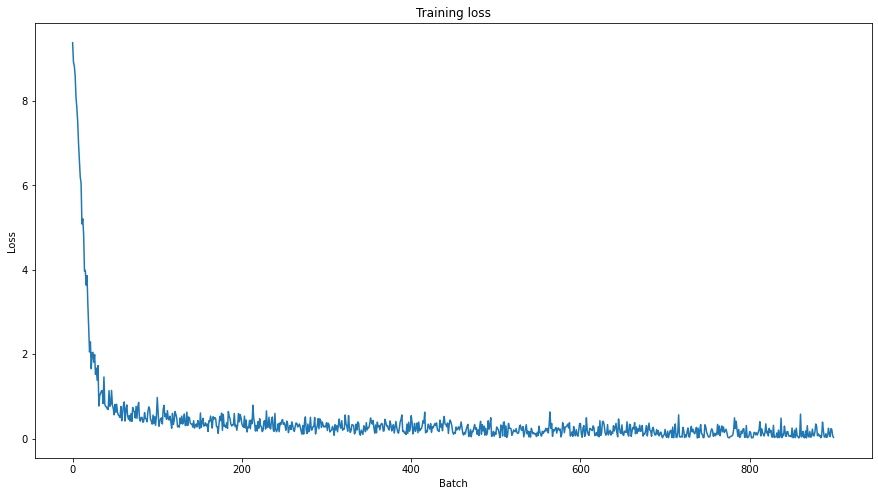

In [21]:
import matplotlib.pyplot as plt
% matplotlib inline

plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

Test model on testing data.

In [22]:
DATA_NAME = "EBA1415-CoralBleaching-little-sentences.tsv"

df_test = pd.read_csv(DATA_PATH + DATA_NAME, delimiter='\t', header=None, names=['essay', 'relation', 's_num', 'sentence'])

df_test.head(50)

,essay,relation,s_num,sentence
0,EBA1415_TFBM_2_CB_ES-05548,O,1.0,No essay //
1,EBA1415_TRJA_11_CB_ES-06110,O,2.0,Somethings that lead to the differences are.. ...
2,EBA1415_TRJA_11_CB_ES-06110,O,3.0,Some have been bleach all white it is a phenom...
3,EBA1415_TRJA_11_CB_ES-06110,O,4.0,Coral bleaching is most noticeable in the Paci...
4,EBA1415_TRJA_11_CB_ES-06110,O,5.0,That ocean covers about 1/3 of the surface of ...
5,EBA1415_TRJA_11_CB_ES-06110,O,6.0,The invertebrate animals live together in Colo...
6,EBA1415_TRJA_11_CB_ES-06110,R-7-50,7.0,The different type of algae living within the ...
7,EBA1415_RHSG_2_CB_ES-05081,R-1-50,8.0,There are several things that cause coral blea...
8,EBA1415_RHSG_2_CB_ES-05081,O,9.0,The trade winds make sea water rise.
9,EBA1415_RHSG_2_CB_ES-05081,R-1-3,10.0,The trade winds also change water temperature


Convert testing data labels to ternary.

In [23]:
relations_test_pd = df_test.relation.copy(deep=True)
df_ternary_test = df_test.copy(deep=True)

for i, rel in relations_test_pd.items():
  chain = rel.split("-")

  if chain[0] == "O":
    relations_test_pd.at[i] = 0
    continue
  
  chain = chain[1] + "," + chain[2]

  if chain in relations:
    relations_test_pd.at[i] = 1
  else: 
    relations_test_pd.at[i] = 2

df_ternary_test.relation = relations_test_pd
df_ternary_test.head(50)

,essay,relation,s_num,sentence
0,EBA1415_TFBM_2_CB_ES-05548,0,1.0,No essay //
1,EBA1415_TRJA_11_CB_ES-06110,0,2.0,Somethings that lead to the differences are.. ...
2,EBA1415_TRJA_11_CB_ES-06110,0,3.0,Some have been bleach all white it is a phenom...
3,EBA1415_TRJA_11_CB_ES-06110,0,4.0,Coral bleaching is most noticeable in the Paci...
4,EBA1415_TRJA_11_CB_ES-06110,0,5.0,That ocean covers about 1/3 of the surface of ...
5,EBA1415_TRJA_11_CB_ES-06110,0,6.0,The invertebrate animals live together in Colo...
6,EBA1415_TRJA_11_CB_ES-06110,1,7.0,The different type of algae living within the ...
7,EBA1415_RHSG_2_CB_ES-05081,1,8.0,There are several things that cause coral blea...
8,EBA1415_RHSG_2_CB_ES-05081,0,9.0,The trade winds make sea water rise.
9,EBA1415_RHSG_2_CB_ES-05081,1,10.0,The trade winds also change water temperature


Identify duplicates in test set.


In [24]:
df_duplicate_sentences_test = df_ternary_test[df_ternary_test.s_num.astype(str).str.split('.', expand=True)[1] != '0']
df_duplicate_sentences_test.head(25)

,essay,relation,s_num,sentence
20,EBA1415_KYNS_4_CB_ES-05390,1,21.1,Weaker trade winds cause higher water temperat...
21,EBA1415_KYNS_4_CB_ES-05390,1,21.2,Weaker trade winds cause higher water temperat...
29,EBA1415_KYNS_4_CB_ES-05390,1,29.1,When the water temperature is constantly chang...
30,EBA1415_KYNS_4_CB_ES-05390,1,29.2,When the water temperature is constantly chang...
31,EBA1415_KYNS_4_CB_ES-05390,1,30.1,Coral bleaching happens when the coral is unhe...
32,EBA1415_KYNS_4_CB_ES-05390,1,30.2,Coral bleaching happens when the coral is unhe...
33,EBA1415_KYNS_4_CB_ES-05390,1,31.1,Trade winds affect the balance of water temper...
34,EBA1415_KYNS_4_CB_ES-05390,1,31.2,Trade winds affect the balance of water temper...
37,EBA1415_KYNS_4_CB_ES-05390,2,34.1,"When the zooxanthellae dies or is ejected, the..."
38,EBA1415_KYNS_4_CB_ES-05390,1,34.2,"When the zooxanthellae dies or is ejected, the..."


Remove duplicates from test set.

In [25]:
current = -1

same_arr_inds = []
drop_list = []

for i, row in df_duplicate_sentences_test.iterrows():
  s_num = str(df_duplicate_sentences_test.loc[i].s_num)
  first_num, second_num = s_num.split(".")

  if first_num != current:
    current = first_num

    if len(same_arr_inds) > 1:

      valid_flag = False
      invalid_flag = False

      for n in same_arr_inds:

        if df_duplicate_sentences_test.loc[n].relation == 1:
          valid_flag = True
          break

        if df_duplicate_sentences_test.loc[n].relation == -1:
          invalid_flag = True 

      left = same_arr_inds[0]
      right = same_arr_inds[1:]

      if valid_flag == True:
        df_duplicate_sentences_test.loc[left].relation = 1
      elif invalid_flag == True:
        df_duplicate_sentences_test.loc[left].relation = -1
      else:
        df_duplicate_sentences_test.loc[left].relation = 0

      drop_list += right   

    same_arr_inds = []
  same_arr_inds.append(i)

df_ternary_test.drop(drop_list, inplace=True)   

df_ternary_test.head(25)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,essay,relation,s_num,sentence
0,EBA1415_TFBM_2_CB_ES-05548,0,1.0,No essay //
1,EBA1415_TRJA_11_CB_ES-06110,0,2.0,Somethings that lead to the differences are.. ...
2,EBA1415_TRJA_11_CB_ES-06110,0,3.0,Some have been bleach all white it is a phenom...
3,EBA1415_TRJA_11_CB_ES-06110,0,4.0,Coral bleaching is most noticeable in the Paci...
4,EBA1415_TRJA_11_CB_ES-06110,0,5.0,That ocean covers about 1/3 of the surface of ...
5,EBA1415_TRJA_11_CB_ES-06110,0,6.0,The invertebrate animals live together in Colo...
6,EBA1415_TRJA_11_CB_ES-06110,1,7.0,The different type of algae living within the ...
7,EBA1415_RHSG_2_CB_ES-05081,1,8.0,There are several things that cause coral blea...
8,EBA1415_RHSG_2_CB_ES-05081,0,9.0,The trade winds make sea water rise.
9,EBA1415_RHSG_2_CB_ES-05081,1,10.0,The trade winds also change water temperature


Let's take a look at the class breakdown for the test set.

In [26]:
df_ternary_test["relation"].value_counts()

0    1474
1     587
2      18
Name: relation, dtype: int64

Extract sentences and labels from test data.

In [27]:
sentences_test = df_ternary_test.sentence.values
sentences_test = ["[CLS] " + sentence + " [SEP]" for sentence in sentences_test]

tokenized_texts_test = [tokenizer.tokenize(sentence) for sentence in sentences_test]
labels_test = df_ternary_test.relation.values.astype(int)
labels_test

array([0, 0, 0, ..., 0, 0, 0])

Tokenize test set essays.

In [28]:
input_ids_test = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_test]
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Set test set attention masks.

In [29]:
attention_masks_test = []

for seq in input_ids_test:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_test.append(seq_mask)

Tensorize and load data.

In [30]:
prediction_inputs = torch.tensor(input_ids_test)
prediction_masks = torch.tensor(attention_masks_test)
prediction_labels = torch.tensor(labels_test)

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=BATCH_SIZE)

Evaluate test set.

In [31]:
model.eval()

predictions_test, true_labels_test = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits_test = logits.detach().cpu().numpy()
  label_ids_test = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions_test.append(logits_test)
  true_labels_test.append(label_ids_test)

Print confusion matrix.

In [32]:
from sklearn.metrics import confusion_matrix

flat_predictions_test = [item for sublist in predictions_test for item in sublist]
flat_predictions_test = np.argmax(flat_predictions_test, axis=1).flatten()
flat_true_labels_test = [item for sublist in true_labels_test for item in sublist]

y_pred = flat_predictions_test
y = flat_true_labels_test

stats = confusion_matrix(y, y_pred).ravel()

print("\t\t\t      Predicted\n")
print("\t\t\tNone\tValid\tInvalid")
print("\n\t\tNone\t{}     {}        {}".format(stats[0], stats[1], stats[2]))
print("      Actual")
print("\t\tValid\t{}      {}        {}".format(stats[3], stats[4], stats[5]))
print("\n\t\tInvalid\t {}       {}        {}".format(stats[6], stats[7], stats[8]))

			      Predicted

			None	Valid	Invalid

		None	1280     194        0
      Actual
		Valid	73      514        0

		Invalid	 5       13        0


Examine statistics from test set.

In [33]:
from sklearn.metrics import classification_report

classification_dict = classification_report(y, y_pred, labels=None, target_names=None, \
                      sample_weight=None, digits=2, output_dict=True, zero_division=1)

for k,v in classification_dict.items():
  print(k, v)

0 {'precision': 0.9425625920471281, 'recall': 0.8683853459972863, 'f1-score': 0.903954802259887, 'support': 1474}
1 {'precision': 0.7128987517337032, 'recall': 0.8756388415672913, 'f1-score': 0.7859327217125381, 'support': 587}
2 {'precision': 1.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 18}
accuracy 0.862914862914863
macro avg {'precision': 0.8851537812602771, 'recall': 0.5813413958548592, 'f1-score': 0.5632958413241417, 'support': 2079}
weighted avg {'precision': 0.878214924456542, 'recall': 0.862914862914863, 'f1-score': 0.8628051400559564, 'support': 2079}
